In [1]:
import pystruct.models as pm
import pystruct.learners as pl

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pylab as plt
import os


from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))
%matplotlib inline

In [2]:
!ls ./input/train/ | wc -l
!ls ./input/train_masks/ | wc -l
!ls ./input/test/ | wc -l

5088
5088
ls: cannot access './input/test/': No such file or directory
0


In [3]:
!ls ./input/train/ | grep c_01.jpg

00087a6bd4dc_01.jpg
0ee135a3cccc_01.jpg
11fcda0a9e1c_01.jpg
2267f4aa0d2c_01.jpg
344ece157efc_01.jpg
3f8d611822bc_01.jpg
430f0cb5666c_01.jpg
4bea0766c14c_01.jpg
4f1f065d78ac_01.jpg
5588758ee21c_01.jpg
8d5423cb763c_01.jpg
b1a27da4f01c_01.jpg
d8e1c401ac3c_01.jpg


In [4]:

from glob import glob

INPUT_PATH = './input'
DATA_PATH = INPUT_PATH
TRAIN_DATA = os.path.join(DATA_PATH, "train")
TRAIN_MASKS_DATA = os.path.join(DATA_PATH, "train_masks")
TEST_DATA = os.path.join(DATA_PATH, "test")

In [5]:
train_files = glob(os.path.join(TRAIN_DATA, "*.jpg"))
train_ids = [s[len(TRAIN_DATA)+1:-4] for s in train_files]


In [6]:
def get_filename(image_id, image_type):
    check_dir = False
    if "Train" == image_type:
        ext = 'jpg'
        data_path = TRAIN_DATA
        suffix = ''
    elif "Train_mask" in image_type:
        ext = 'gif'
        data_path = TRAIN_MASKS_DATA
        suffix = '_mask'
    elif "Test" in image_type:
        ext = 'jpg'
        data_path = TEST_DATA
        suffix = ''
    else:
        raise Exception("Image type '%s' is not recognized" % image_type)

    if check_dir and not os.path.exists(data_path):
        os.makedirs(data_path)

    return os.path.join(data_path, "{}{}.{}".format(image_id, suffix, ext))

In [7]:
import cv2
from PIL import Image


def get_image_data(image_id, image_type, **kwargs):
    if 'mask' in image_type:
        img = _get_image_data_pil(image_id, image_type, **kwargs)
    else:
        img = _get_image_data_opencv(image_id, image_type, **kwargs)
    return img

def _get_image_data_opencv(image_id, image_type, **kwargs):
    fname = get_filename(image_id, image_type)
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def _get_image_data_pil(image_id, image_type, return_exif_md=False, return_shape_only=False):
    fname = get_filename(image_id, image_type)
    try:
        img_pil = Image.open(fname)
    except Exception as e:
        assert False, "Failed to read image : %s, %s. Error message: %s" % (image_id, image_type, e)

    if return_shape_only:
        return img_pil.size[::-1] + (len(img_pil.getbands()),)

    img = np.asarray(img_pil)
    assert isinstance(img, np.ndarray), "Open image is not an ndarray. Image id/type : %s, %s" % (image_id, image_type)
    if not return_exif_md:
        return img
    else:
        return img, img_pil._getexif()


Image shape: (1280, 1918, 3) | image type: uint8 | mask shape: (1280, 1918) | mask type: uint8


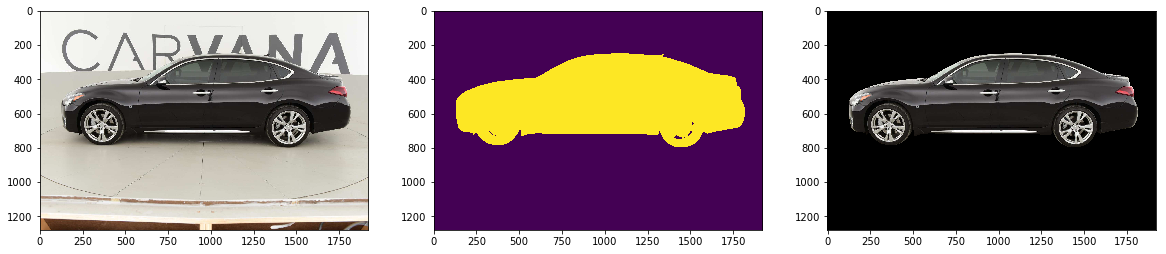

In [8]:
image_id = train_ids[0]

plt.figure(figsize=(20, 20))
img = get_image_data(image_id, "Train")
mask = get_image_data(image_id, "Train_mask")
img_masked = cv2.bitwise_and(img, img, mask=mask)

print("Image shape: {} | image type: {} | mask shape: {} | mask type: {}".format(img.shape, img.dtype, mask.shape, mask.dtype) )

plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(mask)
plt.subplot(133)
plt.imshow(img_masked)

In [9]:
img.shape

(1280, 1918, 3)

In [31]:
nodes = np.reshape(np.arange(img.shape[0]*img.shape[1]),(img.shape[0],img.shape[1]))

In [33]:
nodes

array([[      0,       1,       2, ...,    1915,    1916,    1917],
       [   1918,    1919,    1920, ...,    3833,    3834,    3835],
       [   3836,    3837,    3838, ...,    5751,    5752,    5753],
       ..., 
       [2449286, 2449287, 2449288, ..., 2451201, 2451202, 2451203],
       [2451204, 2451205, 2451206, ..., 2453119, 2453120, 2453121],
       [2453122, 2453123, 2453124, ..., 2455037, 2455038, 2455039]])

In [62]:
end_nodes1 = np.roll(nodes,1)

In [63]:
end_nodes1

array([[2455039,       0,       1, ...,    1914,    1915,    1916],
       [   1917,    1918,    1919, ...,    3832,    3833,    3834],
       [   3835,    3836,    3837, ...,    5750,    5751,    5752],
       ..., 
       [2449285, 2449286, 2449287, ..., 2451200, 2451201, 2451202],
       [2451203, 2451204, 2451205, ..., 2453118, 2453119, 2453120],
       [2453121, 2453122, 2453123, ..., 2455036, 2455037, 2455038]])

In [68]:
end_nodes2 = np.roll(nodes,1,axis=0)

In [69]:
end_nodes2

array([[2453122, 2453123, 2453124, ..., 2455037, 2455038, 2455039],
       [      0,       1,       2, ...,    1915,    1916,    1917],
       [   1918,    1919,    1920, ...,    3833,    3834,    3835],
       ..., 
       [2447368, 2447369, 2447370, ..., 2449283, 2449284, 2449285],
       [2449286, 2449287, 2449288, ..., 2451201, 2451202, 2451203],
       [2451204, 2451205, 2451206, ..., 2453119, 2453120, 2453121]])

In [81]:
start_nodes = np.append(nodes[1:],nodes[1:])

In [82]:
start_nodes.shape

(4906244,)

In [83]:
end_nodes = np.append(end_nodes1[1:], end_nodes2[1:])

In [84]:
end_nodes.shape

(4906244,)

In [58]:
end_nodes = np.arange(img.shape[1],img.shape[0]*img.shape[1])

In [59]:
end_nodes

array([   1918,    1919,    1920, ..., 2455037, 2455038, 2455039])

In [10]:
imgvector = np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))

In [11]:
imgvector.shape

(2455040, 3)

In [12]:
model = pm.GraphCRF(directed=True, inference_method="max-product")

In [13]:
ssvm = pl.FrankWolfeSSVM(model=model, C=.1, max_iter=10)

In [14]:
ssvm.fit(X_train, y_train) 

NameError: name 'X_train' is not defined